In [3]:
pip install overcomplete 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 112.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88

In [4]:
!pip install "numpy<2.0" "pyarrow>=21.0.0" "scikit-learn>=1.6" --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 106.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 45.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 139.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 60.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.6.0
    Uninstalling threadpoolctl-3.6.0:
      Successfully uninstalled threadpoolctl-3.6.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 19.0.1
    Uninstalling pyarrow-19.0.1:
      Successfully uninstalled pyarrow-19.0.1
  Attempting uninstall: numpy
    Found existing installation:

In [1]:
from overcomplete.sae.losses import top_k_auxiliary_loss
from einops import rearrange

In [2]:
import torch
import timm
import numpy as np
from torchvision import models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torchvision

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.Resize(256),        
    transforms.CenterCrop(224),    
    transforms.ToTensor(),
    normalize,
])


dataset = datasets.STL10(
    root='./data', 
    split='unlabeled',    
    download=True, 
    transform=transform
)

device = "cuda" if torch.cuda.is_available() else "cpu"
loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)

print(f"Size : {len(dataset)}")

Size : 100000


In [4]:
class ActivationHook:
    def __init__(self, name, module):
        self.name = name
        self.hook = module.register_forward_hook(self.hook_fn)
        self.activation = None

    def hook_fn(self, module, inp, out):
        if self.name == "ViT":
            out = out[:, 1:, :]     
        self.activation = rearrange(out, "n t d -> (n t) d")
        
    def close(self):
        self.hook.remove()


class DiskDataset(torch.utils.data.Dataset):
    def __init__(self, filename, num_images, num_models, tokens, latent_dim):
        self.data = np.memmap(filename, dtype='float16', mode='r', 
                              shape=(num_images, 2, tokens, latent_dim))
    def __len__(self): 
        return len(self.data)
    
    def __getitem__(self, idx): 
        return torch.from_numpy(self.data[idx].copy()).float()



In [5]:
model_A = timm.create_model(
    'vit_base_patch16_siglip_224', 
    pretrained=True
).to(device)
hook_A = ActivationHook("SigLIP", model_A.norm)

model_B = torchvision.models.vit_b_16(weights='DEFAULT').to(device).eval()
hook_B = ActivationHook("ViT", model_B.encoder.ln)

dummy_img = torch.randn(1, 3, 224, 224).to(device)

with torch.no_grad():
    model_A(dummy_img)
    model_B(dummy_img)

models = [model_A, model_B]
hooks  = [hook_A, hook_B]
print(f"SigLIP Feature Shape: {hook_A.activation.shape}") 
print(f"ViT-L Feature Shape: {hook_B.activation.shape}") 

input_shapes = [hook_A.activation.shape[-1], hook_B.activation.shape[-1]]

SigLIP Feature Shape: torch.Size([196, 768])
ViT-L Feature Shape: torch.Size([196, 768])


In [6]:
import numpy as np
import os
import torch
from tqdm import tqdm

N_IMAGES = len(dataset)
DIM = 768
TOKENS_TO_SAVE = 45 

disk_shape = (N_IMAGES, 2, TOKENS_TO_SAVE, DIM)
filename = '/kaggle/working/activations.dat'
fp = np.memmap(filename, dtype='float16', mode='w+', shape=disk_shape)
ptr = 0

with torch.no_grad():
    for X, _ in tqdm(loader):
        batch_size = X.shape[0]            
        X = X.to(device)
        
        model_A(X)
        model_B(X)

        raw_A = hook_A.activation.detach().half().cpu().numpy()
        raw_B = hook_B.activation.detach().half().cpu().numpy()
        
        act_A = raw_A.reshape(batch_size, -1, DIM)
        act_B = raw_B.reshape(batch_size, -1, DIM)
        
        num_tokens = act_A.shape[1]
        indices = torch.randperm(num_tokens)[:TOKENS_TO_SAVE]
        
        act_A_small = act_A[:, indices, :]
        act_B_small = act_B[:, indices, :]
        
        fp[ptr : ptr + batch_size, 0] = act_A_small
        fp[ptr : ptr + batch_size, 1] = act_B_small
        
        ptr += batch_size
        if ptr % (batch_size * 10) == 0:
            fp.flush()

fp.flush()


100%|██████████| 1563/1563 [21:12<00:00,  1.23it/s]


TypeError: DiskDataset.__init__() missing 2 required positional arguments: 'tokens' and 'latent_dim'

In [49]:
import torch
import torch.nn as nn
from overcomplete import TopKSAE 

class UniversalSAE(nn.Module):
    def __init__(self, input_dims, latent_dim, models, hooks, k=32):
        super().__init__()
        self.num_models = len(input_dims)
        self.models = models
        self.hooks = hooks
        self.saes = nn.ModuleList([
            TopKSAE(
                d, 
                nb_concepts=latent_dim, 
                top_k=k
            ) for d in input_dims
        ])
        self.nb_concepts = latent_dim

    def forward(self, activations, source_idx):
        precodes, codes = self.saes[source_idx].encode(activations[source_idx])
        
        reconstructions = []
        for target_idx in range(self.num_models):
            reconstruction = self.saes[target_idx].decode(codes)
            reconstructions.append(reconstruction)
            
        return reconstructions, precodes, codes

class IndependentSAES(nn.Module):
    def __init__(self, input_dims, latent_dim, models, hooks, k=32):
        super().__init__()
        self.num_models = len(input_dims)
        self.models = models
        self.hooks = hooks
        self.saes = nn.ModuleList([
            TopKSAE(
                d, 
                nb_concepts=latent_dim, 
                top_k=k
            ) for d in input_dims
        ])
        self.nb_concepts = latent_dim
    

    def forward(self, activations, model_idx):
        precodes, codes = self.saes[model_idx].encode(activations)
        reconstruction = self.saes[model_idx].decode(codes)
        return reconstruction, precodes, codes

In [57]:
from tqdm import tqdm
def train_usae(epochs, loader, model_usae, optims, clip_grad):
    losses = list()

    model_usae.to(device)
    for sae in model_usae.saes:
        sae.train()
    
    for epoch in range(epochs):
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}")
        batch_loss = 0
    
        for _, imgs in enumerate(pbar):
            imgs = imgs.to(device)
            imgs = torch.unbind(imgs, dim=1)
            acts = []
            for out in imgs:
                flat = rearrange(out, "n t d -> (n t) d")
                normed = (flat - flat.mean(0)) / (flat.std(0) + 1e-2)
                acts.append(normed)
                
            source_idx = torch.randint(0, len(model_usae.saes), (1,)).item()
            optim = optims[source_idx]
            recons, precodes, codes = model_usae(acts, source_idx)
            
            loss = 0
            for j in range(model_usae.num_models):
                scale = 1.0
                if j != source_idx: scale = 2.0 
                loss += scale * top_k_auxiliary_loss(
                        acts[j],
                        recons[j],
                        precodes,
                        codes,
                        usae.saes[j].get_dictionary(),
                      )
        
            optim.zero_grad()
            loss.backward()
        
            if clip_grad > 0:
                for sae in usae.saes:
                    torch.nn.utils.clip_grad_norm_(sae.parameters(), clip_grad)
            optim.step()
        
            batch_loss += loss.item()
            pbar.set_postfix({'loss': batch_loss/(_+1)})
            
        losses.append(batch_loss / len(loader))

def train_saes(epochs, loader, model_saes, optims, clip_grad):
    model_saes.to(device)
    for sae in model_saes.saes:
        sae.train()
    
    for epoch in range(epochs):
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}")
        batch_losses = [0]*model_saes.num_models
    
        for _, imgs in enumerate(pbar):
            imgs = imgs.to(device)
            imgs = torch.unbind(imgs, dim=1)
            acts = []
            for out in imgs:
                flat = rearrange(out, "n t d -> (n t) d")
                normed = (flat - flat.mean(0)) / (flat.std(0) + 1e-2)
                acts.append(normed)
                
            for i in range(model_saes.num_models):
                loss = 0
                optim = optims[i]
                recons, precodes, codes = model_saes(acts[i], i)
                loss += top_k_auxiliary_loss(
                        acts[i],
                        recons,
                        precodes,
                        codes,
                        model_saes.saes[i].get_dictionary(),
                      )
        
                optim.zero_grad()
                loss.backward()
        
                if clip_grad > 0:
                    torch.nn.utils.clip_grad_norm_(model_saes.saes[i].parameters(), clip_grad)
                
                optim.step()
        
                batch_losses[i] += loss.item()
            pbar.set_postfix({'losses': [batch_loss/(_+1) for batch_loss in batch_losses]})
            
        

In [18]:
fs_dataset = DiskDataset(filename, N_IMAGES, 2, TOKENS_TO_SAVE, DIM)


In [19]:
fs_loader = DataLoader(fs_dataset, batch_size=64, num_workers=2, shuffle=True)

In [20]:
usae = UniversalSAE(input_shapes, 6144, models, hooks, k=32)

In [21]:
optims = [torch.optim.Adam(sae.parameters(), lr=3e-4) for sae in usae.saes]

In [24]:
train_usae(20, fs_loader, usae, optims, clip_grad=1.0)

Epoch 20/20: 100%|██████████| 1563/1563 [02:19<00:00, 11.24it/s, loss=2.11]


In [ ]:
losses = [1.29, .28,.27,1.26,1.25,1.25,1.24,1.24,1.23,1.23,1.23,1.22,1.21,1.2,1.2,1.2,1.2,1.2,1.2 ]
losses = 

In [59]:
saes = IndependentSAES(input_shapes, 6144, models, hooks, k=32)

In [60]:
optims = [torch.optim.Adam(sae.parameters(), lr=3e-4) for sae in saes.saes]

In [61]:
train_saes(10, fs_loader, saes, optims, clip_grad=1.0)

Epoch 10/10: 100%|██████████| 1563/1563 [02:38<00:00,  9.89it/s, losses=[0.19996178668809866, 0.2748293910587894]] 


In [25]:
def calculate_firing_entropy(usae, loader, steps=50):
    usae.eval()
    num_models = usae.num_models
    latent_dim = 6144
    counts = torch.zeros(num_models, latent_dim).to(device) + 1e-9

    with torch.no_grad():
        for i, imgs in enumerate(tqdm(loader, total=steps)):
            if i>=steps : break
            imgs = imgs.to(device)
            
            imgs = torch.unbind(imgs, dim=1)
     
            
            for m_idx in range(num_models):
                flat = rearrange(imgs[m_idx], "n t d -> (n t) d")
                flat = (flat - flat.mean(0)) / (flat.std(0) + 1e-2)
                recodes, codes = usae.saes[m_idx].encode(flat)
                fired_mask = (codes > 0).float()
                counts[m_idx] += fired_mask.sum(dim=0)

    total_firings = counts.sum(dim=0, keepdim=True)
    probs = counts / total_firings
    log_M = np.log(num_models)
    term = probs * torch.log(probs)
    entropy = -1 * term.sum(dim=0) / log_M
    
    entropy[torch.isnan(entropy)] = 0.0
    
    return entropy.cpu().numpy(), counts.cpu().numpy()



def get_cross_reconstruction_matrix(usae, loader):
    usae.eval()
    num_models = usae.num_models
    sse_matrix = torch.zeros(num_models, num_models).to(device)
    sst_matrix = torch.zeros(num_models, num_models).to(device)
    

    with torch.no_grad():
        for i, imgs in enumerate(loader):
           
            imgs = imgs.to(device)
            imgs = torch.unbind(imgs, dim=1)
            
           
            data = []
            for raw in imgs:
                flat = rearrange(raw, "n t d -> (n t) d")
                normed = (flat - flat.mean(0)) / (flat.std(0) + 1e-2)
                data.append(normed)
         
            for src in range(num_models):
                _, z = usae.saes[src].encode(data[src])
                for tgt in range(num_models):
                    recon = usae.saes[tgt].decode(z)
                    target_data = data[tgt]
                    sse_matrix[src, tgt] += ((target_data - recon)**2).sum()
                    sst_matrix[src, tgt] += (target_data**2).sum()
    
    r2_matrix = 1 - (sse_matrix / sst_matrix)
    return r2_matrix.cpu().numpy()


def coordinated_maximization(usae, feature_idx, model_idx, magnitude, steps):

    phase = (torch.rand(1, 3, 224, 113, device=device) * 2 * torch.pi) - torch.pi
    phase.requires_grad = True
    
    optimizer = torch.optim.Adam([phase], lr=0.05)
    jitter = T.RandomAffine(degrees=0, translate=(0.05, 0.05))

    model = usae.models[model_idx]
    hook = usae.hooks[model_idx]
    sae = usae.saes[model_idx]
        
    for i in range(steps):
        optimizer.zero_grad()
    
        real = magnitude * torch.cos(phase)
        imag = magnitude * torch.sin(phase)
        complex_imag = torch.complex(real, imag)
        
        x = torch.fft.irfft2(complex_imag, s=(224, 224), norm='ortho')
        
        img = torch.sigmoid(x)
        img_aug = jitter(img)
        model_in = normalize(img_aug)

        model(model_in)
        act = hook.activation
        act = (act - act.mean(0)) / (act.std(0) + 1e-2)
        
        _, codes = sae.encoder(act)
        
        score = -codes[:, feature_idx].max()
        score.backward()
        optimizer.step()

    real = magnitude * torch.cos(phase)
    imag = magnitude * torch.sin(phase)
    complex_imag = torch.complex(real, imag)
    
    x = torch.fft.irfft2(complex_imag, s=(224, 224), norm='ortho')
    
    img = torch.sigmoid(x)
    model_in = normalize(img)
       

    return img.detach().clamp(0, 1).cpu()

In [26]:
avg_magnitude = 0
steps = len(loader)

for i, (images, _) in enumerate(tqdm(loader)):
    if i >= steps: break
    images = images.to(device)
    fft = torch.fft.rfft2(images, norm='ortho')
    mag = fft.abs()
    avg_magnitude += mag.mean(dim=0) 
    
avg_magnitude = avg_magnitude / steps

100%|██████████| 1563/1563 [02:00<00:00, 12.97it/s]


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.fft
import torchvision.transforms as T
from einops import rearrange

def plot_entropies(entropies):
    sns.histplot(entropies, bins=50, kde=True)
    plt.axvline(0.1, color='red', linestyle='--', label='Model Specific (0.0)')
    plt.axvline(0.9, color='green', linestyle='--', label='Universal (1.0)')
    plt.title("Feature Universality (Firing Entropy)")
    plt.xlabel("Entropy")
    plt.ylabel("Count of Features")
    plt.legend()
    plt.show()
    
def plot_matrix(r2_matrix):
    
    labels = [f"Model {i}" for i in range(r2_matrix.shape[0])]
    sns.heatmap(r2_matrix, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=labels, yticklabels=labels, vmin=0, vmax=1)
    plt.title("Cross-Model Reconstruction ($R^2$)")
    plt.xlabel("Target (Decoder)")
    plt.ylabel("Source (Encoder)")       
    plt.show()

def visualize_consensus(usae, feature_idx, steps=100):
    ims = []
    for model_idx in range(usae.num_models):
         ims.append(coordinated_maximization(usae, feature_idx, model_idx, avg_magnitude, steps))
    return ims


In [28]:
entropies, counts = calculate_firing_entropy(usae, fs_loader, steps=len(fs_loader))
r2_matrix = get_cross_reconstruction_matrix(usae, fs_loader)


100%|██████████| 1563/1563 [00:30<00:00, 51.43it/s]


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


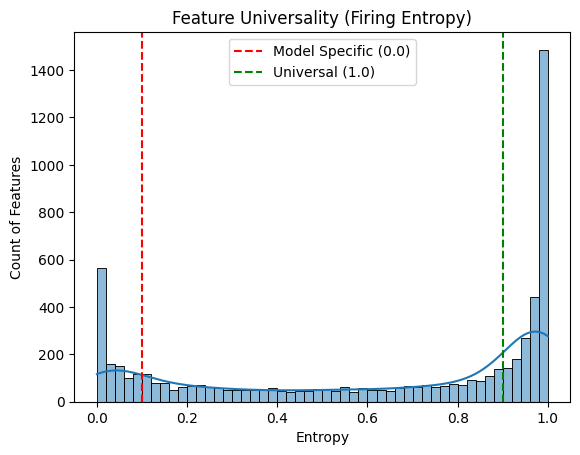

In [29]:
plot_entropies(entropies)

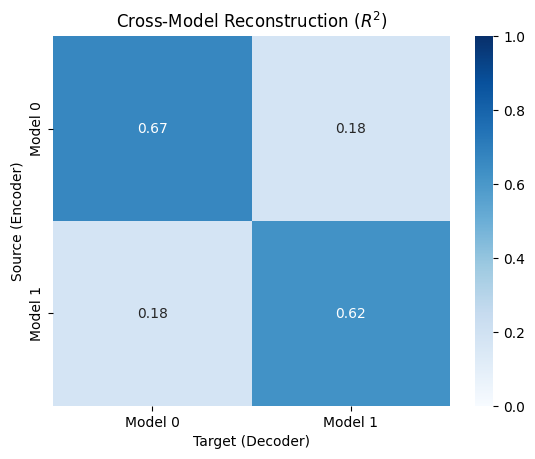

In [30]:
plot_matrix(r2_matrix)

In [31]:
high_ent_idxs = torch.topk(torch.Tensor(entropies), k=20)
high_ent_idxs

torch.return_types.topk(
values=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.]),
indices=tensor([2250,   10, 3786, 1940,  361, 3027,  236, 4133,  686, 3174, 1954, 1802,
        2659, 1753, 4026, 2729, 4499, 3262, 2755, 2159]))

In [ ]:
high_ent_idxs = torch.bottomk(torch.Tensor(entropies), k=20)
high_ent_idxs

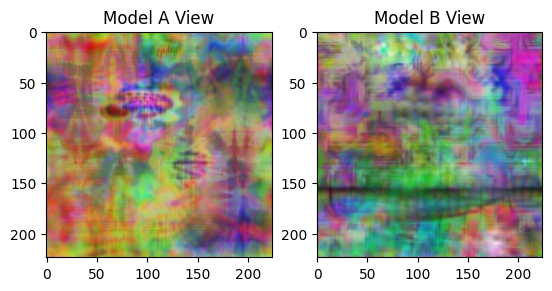

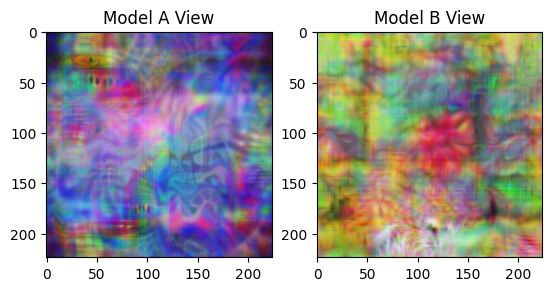

KeyboardInterrupt: 

In [33]:
for high_ent_idx in high_ent_idxs.indices:
    vis_A, vis_B = visualize_consensus(usae, high_ent_idx,  steps=2000)
    
    def show_vis(t1, t2):
        f, ax = plt.subplots(1, 2)
        ax[0].imshow(t1.detach().cpu().squeeze().permute(1,2,0).clamp(0,1))
        ax[0].set_title("Model A View")
        ax[1].imshow(t2.detach().cpu().squeeze().permute(1,2,0).clamp(0,1))
        ax[1].set_title("Model B View")
        plt.show()
    
    show_vis(vis_A, vis_B)

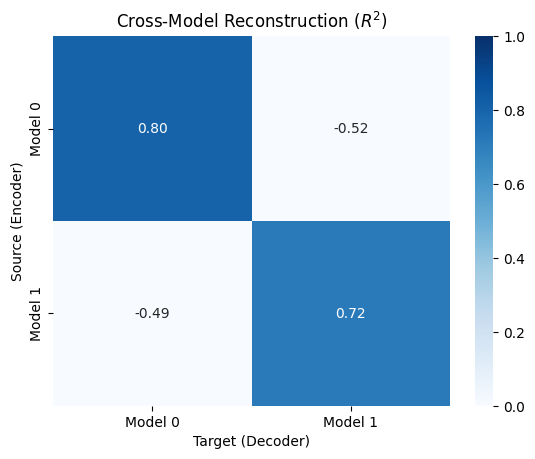

In [62]:
r2_matrix = get_cross_reconstruction_matrix(saes, fs_loader)
plot_matrix(r2_matrix)

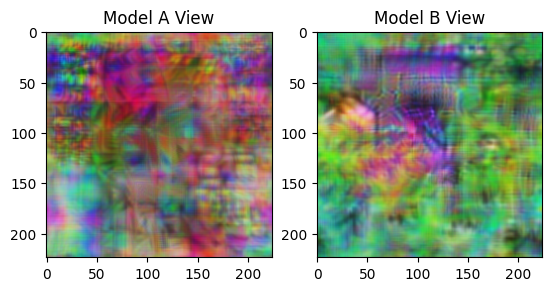

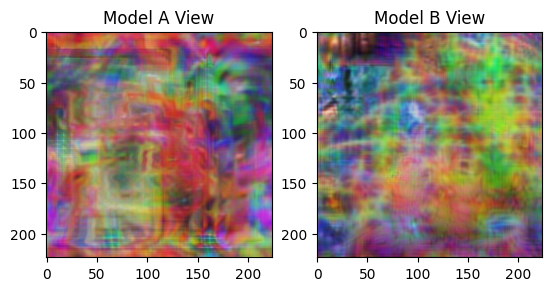

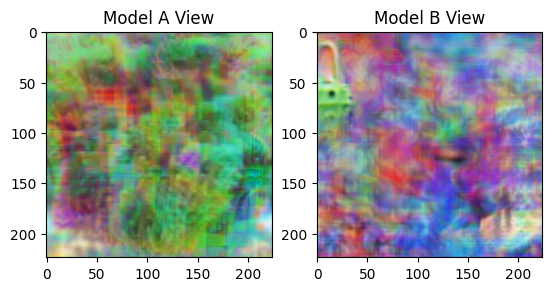

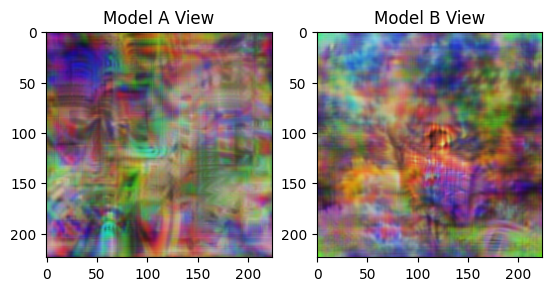

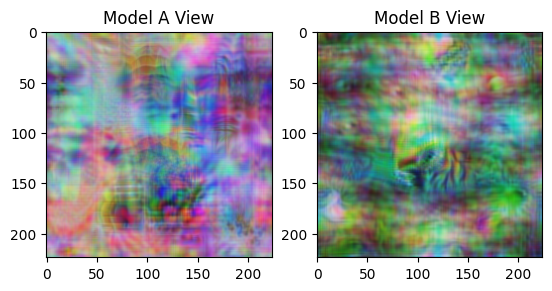

In [64]:
for high_ent_idx in [0, 10, 100, 1000,5000]:
    vis_A, vis_B = visualize_consensus(saes, high_ent_idx,  steps=2000)
    show_vis(vis_A, vis_B)